In [1]:
# Main goal of this excercise is to explore bikes that were stolen or taken for way longer than necessary 

import pandas as pd
import pandas_gbq as gpd
import numpy as np
import tqdm
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import queries as q

project_id = 'cab-law'
client = bigquery.Client(project=project_id)

In [2]:
query = """
    SELECT * FROM `bigquery-public-data.new_york.citibike_trips`
    limit 10;
"""
sample = gpd.read_gbq(query, project_id=project_id, progress_bar_type='tqdm')
sample.head()

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1319,2016-07-15 07:25:54+00:00,2016-07-15 07:47:54+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,520,W 52 St & 5 Ave,40.759923,-73.976485,22950,Subscriber,1989,male
1,1546,2016-07-13 07:54:05+00:00,2016-07-13 08:19:51+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,305,E 58 St & 3 Ave,40.760958,-73.967245,25726,Subscriber,1985,female
2,1241,2016-06-18 14:24:43+00:00,2016-06-18 14:45:24+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,282,Kent Ave & S 11 St,40.707645,-73.968415,23932,Subscriber,1982,female
3,927,2016-03-23 07:11:48+00:00,2016-03-23 07:27:15+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,2022,E 60 St & York Ave,40.759107,-73.959223,14536,Subscriber,1985,male
4,1286,2016-05-09 12:12:07+00:00,2016-05-09 12:33:33+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,2022,E 60 St & York Ave,40.759107,-73.959223,22158,Subscriber,1991,female


In [5]:
info_query = """
    SELECT count(distinct(bikeid)) as num_bikes, count(*) as num_trips, count(distinct(start_station_id)) as num_stations FROM `bigquery-public-data.new_york.citibike_trips`
"""
info = gpd.read_gbq(info_query, project_id=project_id, progress_bar_type='tqdm')
print(info)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|
   num_bikes  num_trips  num_stations
0      11852   33319019           655


In [28]:
full_query = """
select * from `bigquery-public-data.new_york.citibike_trips`
"""
full_results = gpd.read_gbq(full_query, project_id=project_id, use_bqstorage_api=True)


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [33]:
bike_counts = pd.DataFrame(columns=['timestamp', 'station_id', 'bike_change'])

# Create a DataFrame for start stations
start_stations = full_results[['starttime', 'start_station_id']].copy()
start_stations['bike_change'] = -1

# Create a DataFrame for end stations
end_stations = full_results[['stoptime', 'end_station_id']].copy()
end_stations['bike_change'] = 1

# Rename columns for concatenation
start_stations.columns = ['timestamp', 'station_id', 'bike_change']
end_stations.columns = ['timestamp', 'station_id', 'bike_change']

# Concatenate the start and end stations DataFrames
bike_counts = pd.concat([start_stations, end_stations], ignore_index=True)

In [34]:
# Floor the timestamp to the minute
bike_counts['timestamp'] = bike_counts['timestamp'].dt.floor('min')

# Group by timestamp and station_id and sum the bike changes
bike_counts = bike_counts.groupby(['timestamp', 'station_id']).sum().reset_index()

In [39]:
# Let's grab a few of these stations
bike_counts.groupby('station_id')


,timestamp,station_id,bike_change
0,2013-07-01 00:00:00+00:00,164,-1
1,2013-07-01 00:00:00+00:00,388,-1
2,2013-07-01 00:01:00+00:00,293,-2
3,2013-07-01 00:01:00+00:00,382,-1
4,2013-07-01 00:01:00+00:00,511,-1


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1041de110>>
Traceback (most recent call last):
  File "/Users/danepstein/personal_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

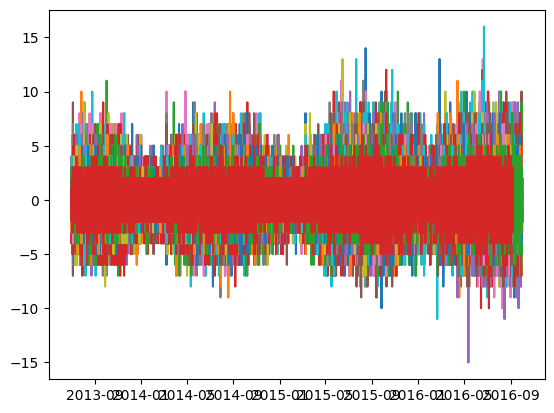

In [37]:
grouped = bike_counts.groupby('station_id')

# Plot bike counts for each station_id
for station_id, group in grouped:
    plt.plot(group['timestamp'], group['bike_change'], label=f'Station {station_id}')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Bike Count')
plt.title('Bike Counts per Station over Time')

# Add legend
plt.legend()

# Show plot
plt.show()